In [5]:
%load_ext autoreload
%autoreload 2

import fastai
from fastai import *

from fastai.vision import *

In [6]:
fastai.__version__

'1.0.58.dev0'

In [7]:
lesson_dir_path = Path('lesson3-camvid')
data_dir_path = untar_data(URLs.CAMVID, dest=lesson_dir_path)

In [8]:
tfms = get_transforms()

In [9]:
codes = np.loadtxt(data_dir_path/'codes.txt', dtype='str')

In [10]:
src = (SegmentationItemList.from_folder(data_dir_path/'images')
                           .split_by_fname_file('valid.txt', path=data_dir_path)
                           .label_from_func(lambda x: data_dir_path/'labels'/'_'.join([x.stem,'P.png']), classes=codes))
src

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/blaberj/fastai_course/lesson3-camvid/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/blaberj/fastai_course/lesson3-camvid/camvid/images;

Test: None

In [11]:
void_code = np.argwhere(codes == 'Void').item()
def acc_camvid(input, targs):
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs != void_code
    return (input[mask] == targs[mask]).float().mean()

In [12]:
native_size = np.array([720, 960])

# Resnet34

### Do size of quarter size first

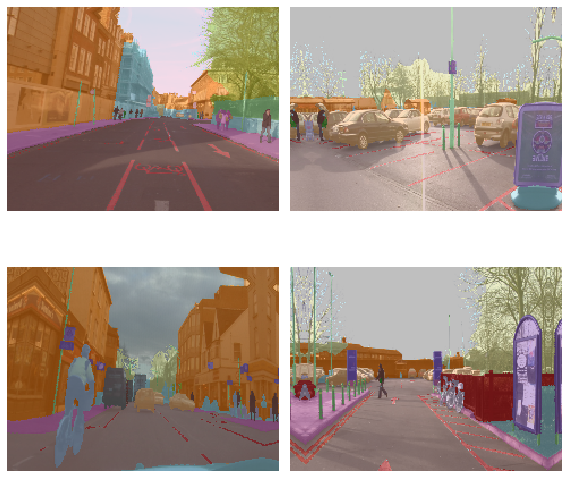

In [9]:
data = (src.transform(tfms, size=native_size//4, tfm_y=True)
           .databunch(bs=32)
           .normalize(imagenet_stats))
data.show_batch(2)

In [10]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


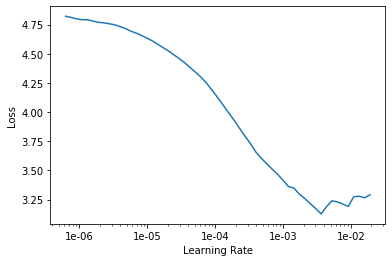

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
lr = 5e-4
learn.fit_one_cycle(40, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,3.576205,2.700047,0.307923,00:15
1,2.700852,1.694642,0.558106,00:13
2,2.143559,1.202369,0.704119,00:13
3,1.751243,0.942316,0.776833,00:13
4,1.472995,0.888213,0.787114,00:13
5,1.262154,0.740152,0.818464,00:13
6,1.107873,0.730923,0.815818,00:13
7,1.002125,0.650563,0.834625,00:13
8,0.911150,0.624590,0.841984,00:13
9,0.825514,0.584904,0.847813,00:13


In [13]:
learn.save('resnet34-base-size_quarter-stage_1')

#### Unfreezing didn't actually seem to improve anything

### Increase size to half

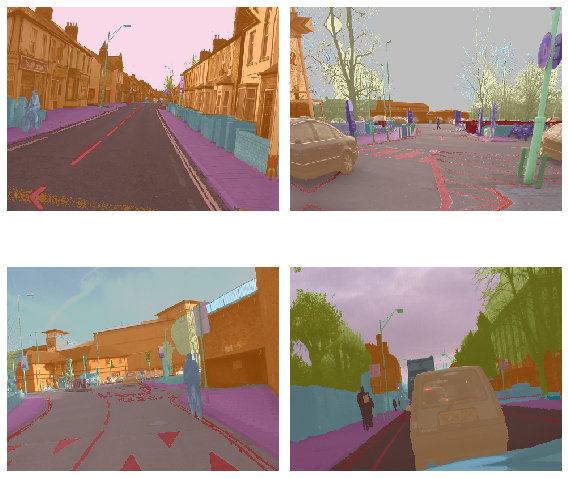

In [9]:
data = (src.transform(tfms, size=native_size//2, tfm_y=True)
           .databunch(bs=8)
           .normalize(imagenet_stats))
data.show_batch(2)

In [13]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid)
learn.load('resnet34-base-size_quarter-stage_1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/blaberj/fastai_course/lesson3-camvid/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/blaberj/fastai_course/lesson3-camvid/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


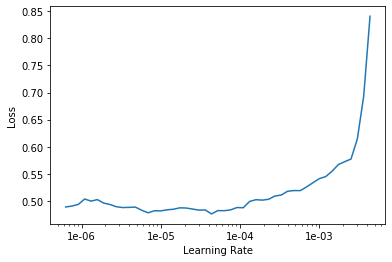

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.438260,0.341563,0.903529,00:43
1,0.408366,0.328216,0.906377,00:43
2,0.393480,0.354917,0.896039,00:42
3,0.370173,0.324730,0.903628,00:42
4,0.343050,0.299754,0.912928,00:40
5,0.323620,0.305813,0.910743,00:41
6,0.313452,0.296794,0.914651,00:40
7,0.302898,0.298094,0.913461,00:41
8,0.290923,0.298688,0.912439,00:41
9,0.286725,0.298065,0.913360,00:41


In [16]:
learn.save('resnet34-base-size_half-stage_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


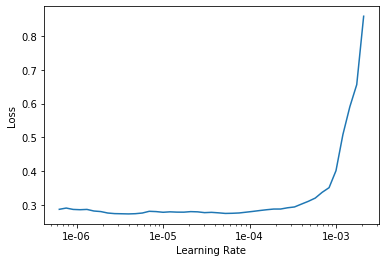

In [19]:
learn.load('resnet34-base-size_half-stage_1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 1e-4
learn.fit_one_cycle(10, slice(1e-6, lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.283033,0.293383,0.914431,00:43
1,0.297085,0.299247,0.913347,00:45
2,0.308987,0.301769,0.910967,00:45
3,0.304083,0.288406,0.916192,00:45
4,0.290195,0.299606,0.912095,00:45
5,0.279487,0.293439,0.914645,00:45
6,0.265655,0.284584,0.917413,00:45
7,0.254862,0.288658,0.917995,00:45
8,0.246063,0.274309,0.920572,00:45
9,0.244703,0.277947,0.919513,00:45


In [21]:
learn.save('resnet34-base-size_half-stage_2')

### Increase size to full size

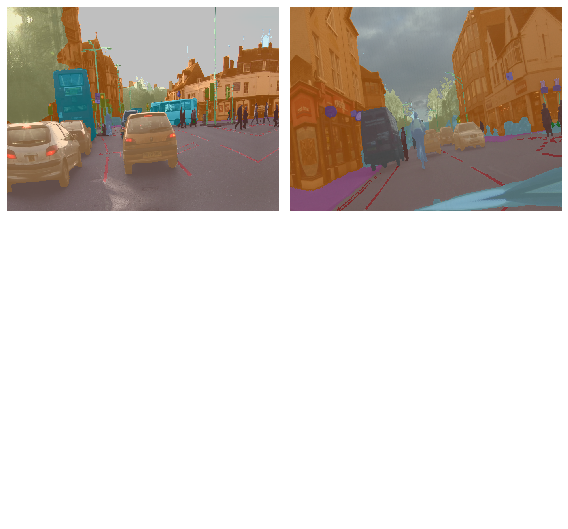

In [13]:
data = (src.transform(tfms, size=native_size, tfm_y=True)
           .databunch(bs=2)
           .normalize(imagenet_stats))
data.show_batch(2)

In [17]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid)
learn.load('resnet34-base-size_half-stage_2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/blaberj/fastai_course/lesson3-camvid/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/blaberj/fastai_course/lesson3-camvid/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


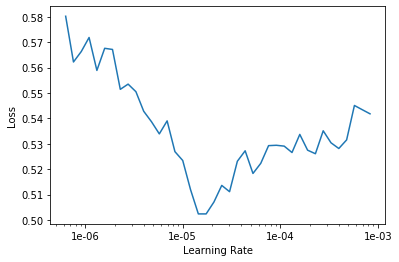

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.425149,0.318549,0.911986,02:53
1,0.418240,0.318304,0.911052,02:53
2,0.408947,0.370731,0.893495,02:53
3,0.369988,0.316922,0.908049,02:54
4,0.340810,0.305632,0.912607,02:54
5,0.313192,0.264896,0.926192,02:53
6,0.280803,0.254480,0.927650,02:54
7,0.253596,0.285401,0.919223,02:54
8,0.228684,0.271669,0.922800,02:53
9,0.232733,0.259330,0.926668,02:54


In [20]:
learn.save('resnet34-base-size_full-stage_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


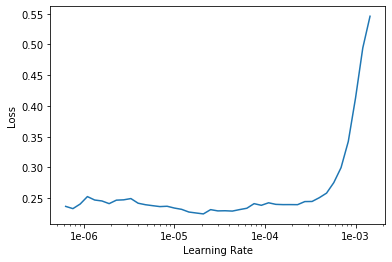

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-4
learn.fit_one_cycle(10, slice(1e-6, lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.246260,0.267122,0.924026,03:18
1,0.286827,0.305283,0.912620,03:08
2,0.311794,0.298996,0.913791,03:08
3,0.282511,0.251854,0.925673,03:12
4,0.265015,0.276064,0.924642,03:08
5,0.226977,0.257883,0.927426,03:09
6,0.207192,0.259264,0.926504,03:08
7,0.204057,0.264552,0.928351,03:08
8,0.187038,0.251216,0.930442,03:08
9,0.191145,0.252346,0.930107,03:09


In [23]:
learn.save('resnet34-base-size_full-stage_2')

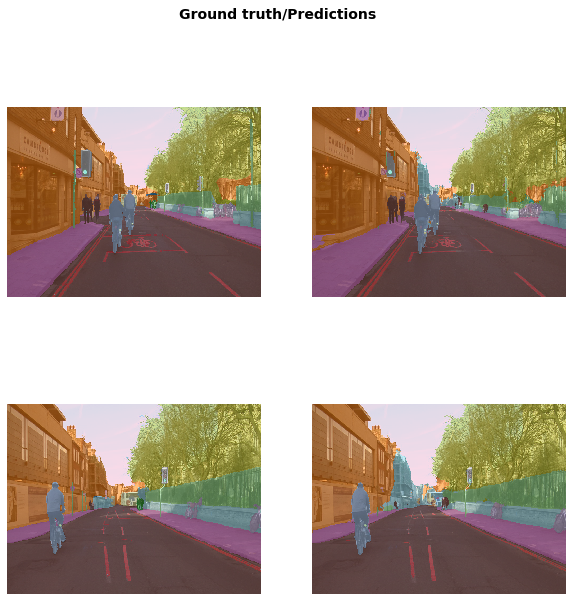

In [24]:
learn.show_results(rows=3, figsize=(10,10))

## TODO: Try starting from half size like in the fastai notebook and also tinker with weight decay and pct_start